In [1]:
!pip install keras-tuner

import os
import warnings
# Silenciamento absoluto antes de importar TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, ops
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# 1. Preparação e Carregamento
df = pd.read_csv('../data/processed/biometria_final_pos.csv')
le = LabelEncoder()
y = le.fit_transform(df['cow_id'])

# Separação das Features
cols_geo = [c for c in df.columns if c.startswith('geo_')]
cols_img_all = [c for c in df.columns if c.startswith('img_')]
cols_img_no_sift = [c for c in cols_img_all if 'sift' not in c]

def create_pairs(X, y):
    """Gera pares positivos e negativos baseados na lógica do notebook 06."""
    pairs, labels = [], []
    unique_classes = np.unique(y)
    class_indices = {c: np.where(y == c)[0] for c in unique_classes}
    
    for idx1 in range(len(X)):
        current_class = y[idx1]
        
        # Par Positivo (Mesmo animal)
        indices_same = class_indices[current_class]
        if len(indices_same) > 1:
            idx2 = np.random.choice(indices_same[indices_same != idx1])
        else:
            idx2 = idx1
        pairs += [[X[idx1], X[idx2]]]
        labels += [1]
        
        # Par Negativo (Animais diferentes)
        other_class = np.random.choice([c for c in unique_classes if c != current_class])
        idx3 = np.random.choice(class_indices[other_class])
        pairs += [[X[idx1], X[idx3]]]
        labels += [0]
        
    return np.array(pairs), np.array(labels).astype('float32')

In [3]:
# 2. Definição do Modelo para Keras Tuner
from tensorflow.keras import ops  # Importante para Keras 3

def build_model(hp, input_dim):
    # Parâmetros Tunáveis
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Shared Branch (Embedding)
    input_branch = Input(shape=(input_dim,))
    x = layers.Dense(hp_units, activation='relu')(input_branch)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.Dense(hp_units // 2, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    branch_model = models.Model(input_branch, x)

    # Entradas Siamesas
    input_l = Input(shape=(input_dim,))
    input_r = Input(shape=(input_dim,))
    
    feat_l = branch_model(input_l)
    feat_r = branch_model(input_r)

    # CORREÇÃO AQUI: Use keras.ops.abs em vez de tf.abs
    diff = ops.abs(feat_l - feat_r)
    
    output = layers.Dense(1, activation='sigmoid')(diff)

    model = models.Model(inputs=[input_l, input_r], outputs=output)
    
    # Configuração do Otimizador
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [4]:
cenarios = {"A (Sem SIFT)": cols_geo + cols_img_no_sift, "B (Com SIFT)": cols_geo + cols_img_all}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nome, cols in cenarios.items():
    print(f"\n🚀 Iniciando Experimento: {nome}")
    X_data = df[cols].values
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y)):
        # Preparação dos dados do Fold
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_data[train_idx])
        X_val_fold = scaler.transform(X_data[val_idx])
        X_train_pairs, y_train_pairs = create_pairs(X_train_fold, y[train_idx])
        X_val_pairs, y_val_pairs = create_pairs(X_val_fold, y[val_idx])

        # CONFIGURAÇÃO DO TUNER PARA BUSCA REAL
        tuner = kt.RandomSearch(
            lambda hp: build_model(hp, X_train_fold.shape[1]),
            objective='val_accuracy',
            max_trials=10, # Aumentado para 10 tentativas por Fold
            executions_per_trial=1, # Quantas vezes treinar cada setup
            directory='tuner_results',
            project_name=f'siamese_{nome.replace(" ", "")}_f{fold}',
            overwrite=True # FORÇA A BUSCA NOVA, ignorando caches antigos
        )

        # A busca acontece aqui. verbose=0 mantém a tela limpa.
        tuner.search([X_train_pairs[:, 0], X_train_pairs[:, 1]], y_train_pairs,
                     validation_data=([X_val_pairs[:, 0], X_val_pairs[:, 1]], y_val_pairs),
                     epochs=25, batch_size=16, verbose=0)

        # Pega o melhor modelo resultante da busca
        best_model = tuner.get_best_models(num_models=1)[0]
        _, acc = best_model.evaluate([X_val_pairs[:, 0], X_val_pairs[:, 1]], y_val_pairs, verbose=0)
        fold_accuracies.append(acc)
        print(f"✅ Fold {fold+1}/5 Finalizado - Acurácia: {acc:.2%}")

    print(f"📊 MÉDIA FINAL {nome}: {np.mean(fold_accuracies):.2%} (+/- {np.std(fold_accuracies)*2:.2%})")


🚀 Iniciando Experimento: A (Sem SIFT)


I0000 00:00:1772162360.109886  279682 service.cc:145] XLA service 0x7d3bb002d5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772162360.109957  279682 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
I0000 00:00:1772162364.108698  279682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✅ Fold 1/5 Finalizado - Acurácia: 78.67%
✅ Fold 2/5 Finalizado - Acurácia: 79.50%
✅ Fold 3/5 Finalizado - Acurácia: 78.00%
✅ Fold 4/5 Finalizado - Acurácia: 80.50%
✅ Fold 5/5 Finalizado - Acurácia: 80.33%
📊 MÉDIA FINAL A (Sem SIFT): 79.40% (+/- 1.92%)

🚀 Iniciando Experimento: B (Com SIFT)
✅ Fold 1/5 Finalizado - Acurácia: 80.00%
✅ Fold 2/5 Finalizado - Acurácia: 80.67%
✅ Fold 3/5 Finalizado - Acurácia: 80.67%
✅ Fold 4/5 Finalizado - Acurácia: 80.33%
✅ Fold 5/5 Finalizado - Acurácia: 82.17%
📊 MÉDIA FINAL B (Com SIFT): 80.77% (+/- 1.48%)


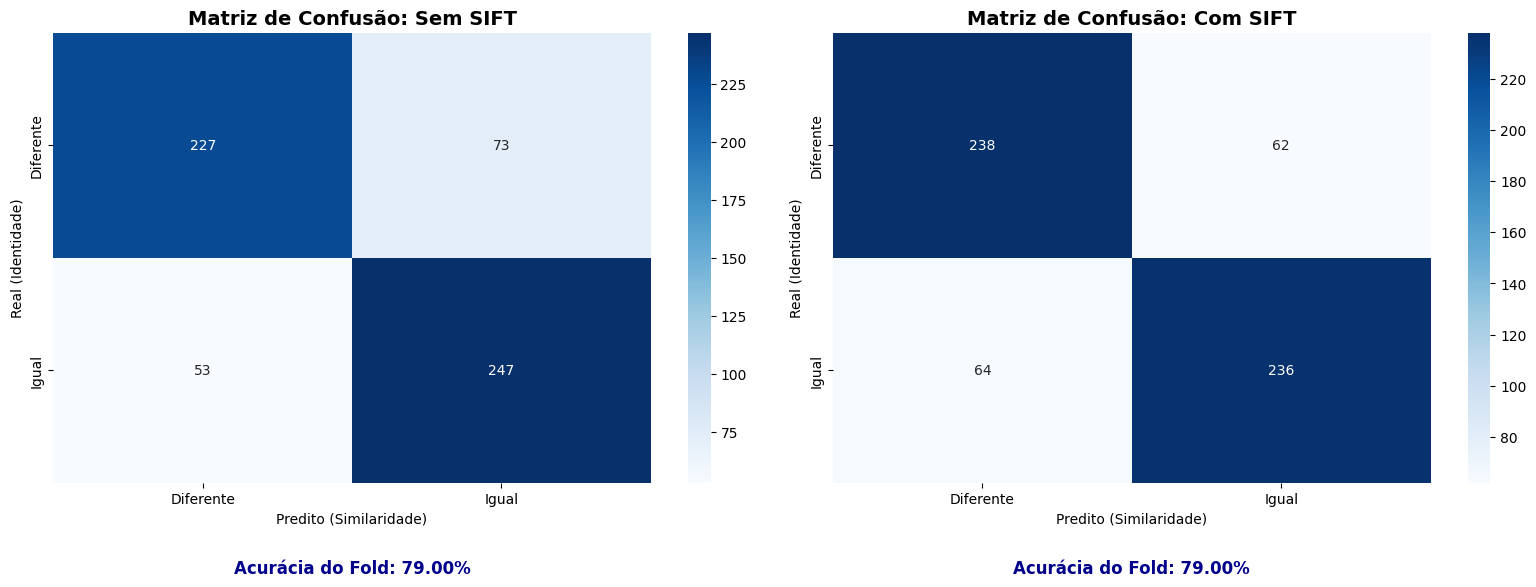

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

# Silenciar logs para focar nos resultados
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def plot_comparative_confusion_matrices(df, y, cols_a, cols_b):
    """
    Treina modelos para os dois cenários e compara as matrizes de confusão lado a lado.
    """
    # 1. Preparação dos dados (usando o mesmo split para comparação justa)
    # Pegamos o primeiro fold do StratifiedKFold definido anteriormente
    idx_train, idx_val = next(skf.split(df, y))
    
    results = {}
    cenarios_config = [("Sem SIFT", cols_a), ("Com SIFT", cols_b)]
    
    for nome, cols in cenarios_config:
        # Extrair dados como matrizes Numpy para evitar erros de indexação de colunas
        X_full = df[cols].values
        
        # Escalonamento isolado por cenário
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_full[idx_train])
        X_val = scaler.transform(X_full[idx_val])
        
        # Criar pares de similaridade (Lógica do Notebook 06)
        X_train_pairs, y_train_pairs = create_pairs(X_train, y[idx_train])
        X_val_pairs, y_val_pairs = create_pairs(X_val, y[idx_val])
        
        # Construir o modelo (usando a função build_model corrigida com ops.abs)
        # Usamos uma busca simples de hiperparâmetros ou valores padrão robustos
        model = build_model(kt.HyperParameters(), X_train.shape[1])
        
        # Treinamento rápido para visualização (ajuste epochs se necessário)
        model.fit([X_train_pairs[:, 0], X_train_pairs[:, 1]], y_train_pairs, 
                  epochs=30, batch_size=16, verbose=0)
        
        # Predição e binarização (threshold 0.5)
        y_probs = model.predict([X_val_pairs[:, 0], X_val_pairs[:, 1]], verbose=0)
        y_pred = (y_probs > 0.5).astype(int).flatten()
        
        results[nome] = {
            'cm': confusion_matrix(y_val_pairs, y_pred),
            'acc': np.mean(y_pred == y_val_pairs)
        }

    # 2. Plotagem Lado a Lado para a Dissertação
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    for ax, (nome, data) in zip([ax1, ax2], results.items()):
        sns.heatmap(data['cm'], annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Diferente', 'Igual'], 
                    yticklabels=['Diferente', 'Igual'])
        ax.set_title(f'Matriz de Confusão: {nome}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Predito (Similaridade)')
        ax.set_ylabel('Real (Identidade)')
        
        # Adicionar acurácia do fold no rodapé do gráfico
        ax.annotate(f'Acurácia do Fold: {data["acc"]:.2%}', xy=(0.5, -0.2), 
                    xycoords='axes fraction', ha='center', fontsize=12, 
                    fontweight='bold', color='darkblue')

    plt.tight_layout()
    plt.show()

# Executar a comparação final
plot_comparative_confusion_matrices(df, y, 
                                   cols_geo + cols_img_no_sift, 
                                   cols_geo + cols_img_all)